In [1]:
import torch
from easy_transformer import EasyTransformer

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f"Using {device} device")
torch.set_grad_enabled(False)

model = EasyTransformer.from_pretrained('gpt2').to(device)

# Convenience function for decoding token
decode = model.tokenizer.decode

# Convenience function for encoding token
def encode(t):
    global model
    result = model.tokenizer.encode(t)
    if len(result) != 1:
        raise Exception(f"Not a single token: {t}")
    return result[0]

unembed = model.unembed.W_U.data
embed = model.embed.W_E.data
d_M = model.cfg.d_model
d_V = model.cfg.d_vocab

unembed_norm = torch.nn.functional.normalize(unembed, dim=0)

Using cpu device
Loading model: gpt2


/home/giles/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
Using pad_token, but it is not set yet.


Moving model to device:  cpu
Finished loading pretrained model gpt2 into EasyTransformer!
Moving model to device:  cpu


In [20]:
n_tests = 100
batch_size = 10

generator = torch.Generator()
generator.manual_seed(12345)
for i in range(0, n_tests, batch_size):
    t0 = torch.randint(0, d_V, (batch_size,), generator=generator)
    t1 = torch.randint(0, d_V, (batch_size,), generator=generator)
    vs = torch.linalg.vector_norm(unembed_norm[:,t0] + unembed_norm[:,t1], dim=0)
    oks = torch.nonzero(vs < 1.2)
    for ok in oks:
        print(vs[ok], decode(t0[ok]), decode(t1[ok]))

[(3.099952152751939e-07, 'isSpecial'), (7.399406740660197e-07, ','), (0.6433819532394409, 'InstoreAndOnline'), (0.6459536552429199, '\x0c'), (0.6463701128959656, '\x10'), (0.6465952396392822, '\x15'), (0.6468637585639954, '\x00'), (0.6470333337783813, '�'), (0.647476851940155, ' サーティ'), (0.6476940512657166, 'rawdownload')]


/home/giles/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/giles/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/giles/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 16 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/giles/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/giles/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/giles/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 125

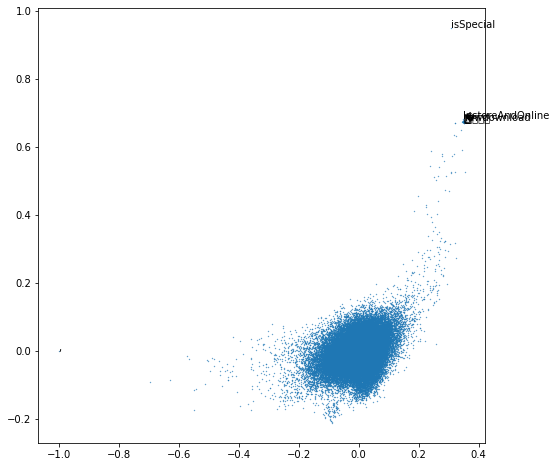

In [18]:
import matplotlib.pyplot as plt
data = torch.zeros((d_M,d_M))
data[0,:] = unembed_norm[:,encode(',')]
data[1,:] = unembed_norm[:,encode('isSpecial')]

#pca = PCA(n_components=2)
#pca.fit(unembed_norm.T)
#data[:2,:] = torch.tensor(pca.components_)

orth = torch.linalg.qr(data.T)[0]

proj = torch.matmul(orth.T, unembed_norm)
plt.rcParams['figure.figsize'] = [8, 8]
xs = proj[0,:]
ys = proj[1,:]
ds = torch.linalg.vector_norm(proj[2:,:], dim=0)

values = [(v.item(),decode(i)) for i,v in enumerate(ds)]
values.sort(reverse=False)
print(values[:10])

plt.scatter(xs, ys, s=0.1)
for i in range(d_V):
    if ds[i] < values[10][0]:
        plt.text(xs[i], ys[i], decode(i), parse_math=False)